<a href="https://colab.research.google.com/github/arniery/thesis/blob/main/miniexperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Remember to use GPU runtime (and restart)
Runtime > Change Runtime Type > GPU

# Clone repo and install requirements

In [1]:
%%bash
git clone https://github.com/nicolalandro/autovc.git
cd autovc
pip install wavenet_vocoder

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wavenet_vocoder: filename=wavenet_vocoder-0.1.1-py3-none-any.whl size=12643 sha256=4b2151bf8c0e38fb3e9bbdeda40afbec21f7ebc8ae95ecc922793f3bfa4b570e
  Stored in directory: /root/.cache/pip/wheels/a5/11/63/fe7245eb0332410c0349aa222181c16496209ac96a7245855c
Successfully built wavenet_vocoder


Cloning into 'autovc'...


In [2]:
%cd autovc

/content/autovc


# Import requirements

In [3]:
import os
import pickle
import torch
import numpy as np
from numpy.random import RandomState
from math import ceil
from collections import OrderedDict

from scipy import signal
from scipy.signal import get_window
import librosa
from librosa.filters import mel
import soundfile as sf
from IPython.display import Audio

import matplotlib.pyplot as plt

from model_bl import D_VECTOR
from model_vc import Generator
from synthesis import build_model
from synthesis import wavegen

# Read Audio

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
!cp -r /content/drive/MyDrive/autovc_data/wav16k ./

In [7]:
!pip install gtts

from gtts import gTTS
import os

os.makedirs('source_wavs', exist_ok=True)

texts = ["I'll go over tomorrow afternoon.", "AutoVC makes voice conversion fun!", "We are testing multiple files."]

for i, text in enumerate(texts, 1):
    tts = gTTS(text=text, lang='en')
    file_path = f'source_wavs/speech{i}.wav'
    tts.save(file_path)
    print(f"Saved {file_path}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1
Saved source_wavs/speech1.wav
Saved source_wavs/speech2.wav
Saved source_wavs/speech3.wav


In [10]:
path1="/content/source_wavs/speech1.wav"
path2="/content/wav16k/female_speaker/train_hindifullfemale_00389_16k.wav"

In [11]:
Audio(path1)

In [12]:
Audio(path2)

# Compute spectrogram
Generate spectrogram by a Short Time Futrie Transform (STFT)

In [13]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a


def pySTFT(x, fft_length=1024, hop_length=256):

    x = np.pad(x, int(fft_length//2), mode='reflect')

    noverlap = fft_length - hop_length
    shape = x.shape[:-1]+((x.shape[-1]-noverlap)//hop_length, fft_length)
    strides = x.strides[:-1]+(hop_length*x.strides[-1], x.strides[-1])
    result = np.lib.stride_tricks.as_strided(x, shape=shape,
                                             strides=strides)

    fft_window = get_window('hann', fft_length, fftbins=True)
    result = np.fft.rfft(fft_window * result, n=fft_length).T

    return np.abs(result)

In [14]:
mel_basis = mel(sr=16000, n_fft=1024, fmin=90, fmax=7600, n_mels=80).T
min_level = np.exp(-100 / 20 * np.log(10))
b, a = butter_highpass(30, 16000, order=5)

In [15]:
def prepare_spectrogram(path, rd_int=None):
    x, fs = sf.read(path)
    y = signal.filtfilt(b, a, x)
    if rd_int is None:
        try:
            # Attempt to extract integer ID from path
            rd_int = int(path.split('/')[-2][1:])
        except ValueError:
            # If extraction fails, use a default random state
            rd_int = 0 # Or some other sensible default/strategy
    prng = RandomState(rd_int) # cosa vuol dire?
    wav = y * 0.96 + (prng.rand(y.shape[0])-0.5)*1e-06
    D = pySTFT(wav).T
    D_mel = np.dot(D, mel_basis)
    D_db = 20 * np.log10(np.maximum(min_level, D_mel)) - 16
    S = np.clip((D_db + 100) / 100, 0, 1)
    S = S.astype(np.float32)
    return S

In [16]:
s1 = prepare_spectrogram(path1, rd_int=255)
print(s1.shape)
s2 = prepare_spectrogram(path2)
print(s2.shape)

(232, 80)
(160, 80)


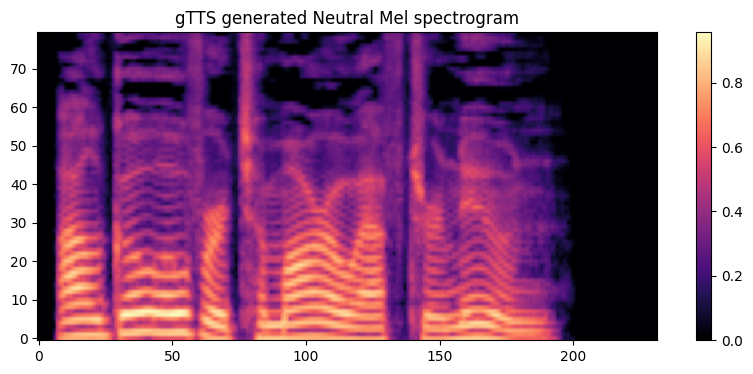

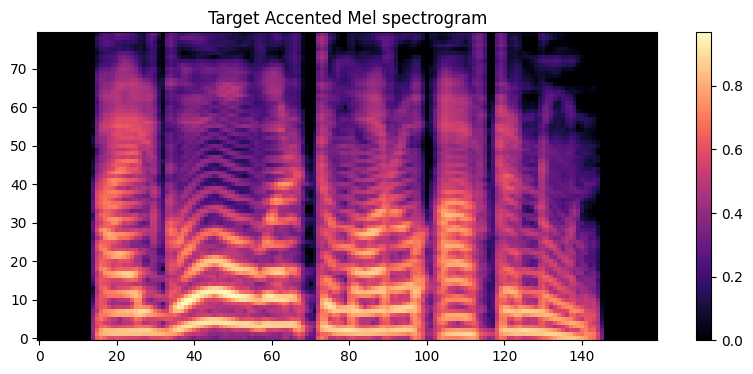

In [17]:
# we can plot these spectrograms

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

# Load a gTTS generated mel spectrogram
# gtts_mel_path = "/content/source_wavs/speech1.wav"
gtts_mel = s1

# Plot the gTTS mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(gtts_mel.T, origin='lower', aspect='auto', cmap='magma')
plt.colorbar()
plt.title("gTTS generated Neutral Mel spectrogram")
plt.show()

# Load a training mel spectrogram
training_mel = s2

# Plot the training mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(training_mel.T, origin='lower', aspect='auto', cmap='magma')
plt.colorbar()
plt.title("Target Accented Mel spectrogram")
plt.show()

# Speaker Encoder
Use model_bl to encode the spectrograms

In [18]:
!wget https://github.com/nicolalandro/autovc/releases/download/0.1/3000000-BL.ckpt

--2025-08-29 17:00:21--  https://github.com/nicolalandro/autovc/releases/download/0.1/3000000-BL.ckpt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/392250635/29880038-d71a-4f2e-986e-0a1e976793f6?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-29T17%3A39%3A36Z&rscd=attachment%3B+filename%3D3000000-BL.ckpt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-08-29T16%3A39%3A27Z&ske=2025-08-29T17%3A39%3A36Z&sks=b&skv=2018-11-09&sig=QNeWHpmHUTA3DyYopRVVYfrmyRR3YLr%2F%2FKW0udQUduQ%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1NjQ4NzEyMSwibmJmIjoxNzU2NDg2ODIxLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ib

In [19]:
C = D_VECTOR(dim_input=80, dim_cell=768, dim_emb=256).eval().cuda()
c_checkpoint = torch.load('3000000-BL.ckpt')
new_state_dict = OrderedDict()
for key, val in c_checkpoint['model_b'].items():
    new_key = key[7:]
    new_state_dict[new_key] = val
C.load_state_dict(new_state_dict)
num_uttrs = 10
len_crop = 128

In [20]:
def process_speacker(tmp):
    left = np.random.randint(0, tmp.shape[0]-len_crop)
    melsp = torch.from_numpy(tmp[np.newaxis, left:left+len_crop, :]).cuda()
    emb = C(melsp)
    return emb.detach().squeeze().cpu().numpy()

In [21]:
emb1 = process_speacker(s1)
print(emb1.shape)
emb2 = process_speacker(s2)
print(emb2.shape)

(256,)
(256,)


# AutoVC
It use the model_vc to decode both data: input and style

In [22]:
!wget https://github.com/nicolalandro/autovc/releases/download/0.1/autovc.ckpt

--2025-08-29 17:00:34--  https://github.com/nicolalandro/autovc/releases/download/0.1/autovc.ckpt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/392250635/e92e4b8d-f850-4e55-93bf-243b39fbf1f0?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-29T17%3A38%3A04Z&rscd=attachment%3B+filename%3Dautovc.ckpt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-08-29T16%3A37%3A23Z&ske=2025-08-29T17%3A38%3A04Z&sks=b&skv=2018-11-09&sig=ErV45MvmEnXJbMLOCF1xAo4%2BKcntYVvcmgZGWCijSH0%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1NjQ4NzEzNSwibmJmIjoxNzU2NDg2ODM1LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLmNvcmU

In [23]:
def pad_seq(x, base=32):
    len_out = int(base * ceil(float(x.shape[0])/base))
    len_pad = len_out - x.shape[0]
    assert len_pad >= 0
    return np.pad(x, ((0,len_pad),(0,0)), 'constant'), len_pad

In [24]:
device = 'cuda:0'
G = Generator(32,256,512,32).eval().to(device)

g_checkpoint = torch.load('autovc.ckpt', map_location=device)
G.load_state_dict(g_checkpoint['model'])

<All keys matched successfully>

In [25]:
def prepare_input(s1, emb1, emb2):
    x_org, len_pad = pad_seq(s1)
    uttr_org = torch.from_numpy(x_org[np.newaxis, :, :]).to(device)
    emb_org = torch.from_numpy(emb1[np.newaxis, :]).to(device)

    emb_trg = torch.from_numpy(emb2[np.newaxis, :]).to(device)

    with torch.no_grad():
            _, x_identic_psnt, _ = G(uttr_org, emb_org, emb_trg)
    if len_pad == 0:
        uttr_trg = x_identic_psnt[0, 0, :, :].cpu().numpy()
    else:
        uttr_trg = x_identic_psnt[0, 0, :-len_pad, :].cpu().numpy()
    return uttr_trg

In [26]:
spect_vc1 = prepare_input(s1, emb1, emb2)
print(spect_vc1.shape)

(232, 80)


# Vocoder
Generate .wav audio file from generated spectrogram

In [27]:
!wget https://github.com/nicolalandro/autovc/releases/download/0.1/checkpoint_step001000000_ema.pth

--2025-08-29 17:02:05--  https://github.com/nicolalandro/autovc/releases/download/0.1/checkpoint_step001000000_ema.pth
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/392250635/39f09916-7fba-470c-81eb-5f4e214ce61e?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-29T17%3A37%3A19Z&rscd=attachment%3B+filename%3Dcheckpoint_step001000000_ema.pth&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-08-29T16%3A36%3A50Z&ske=2025-08-29T17%3A37%3A19Z&sks=b&skv=2018-11-09&sig=6EDDlpwIKkeYgjkv%2BR3geBjKbP9%2B3Vcn%2BSVMbcP9JAI%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1NjQ4NzIyNSwibmJmIjoxNzU2NDg2OTI1LCJwYXRoI

In [28]:
device = torch.device("cuda")
model = build_model().to(device)
checkpoint = torch.load("checkpoint_step001000000_ema.pth", weights_only=False)
model.load_state_dict(checkpoint["state_dict"])

/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


<All keys matched successfully>

In [29]:
file_output = "a_b.wav"
waveform = wavegen(model, c=spect_vc1)
sf.write(file_output, waveform, 16000, 'PCM_24')

100%|██████████| 59392/59392 [11:27<00:00, 86.43it/s]


In [30]:
Audio(file_output)